<a id="top"></a>
# Surveying dust structure via GALEX MIS - Part 1
***

## Learning goals

By the end of this tutorial you will be able to:

- Understand UV images and how they are useful to study dust
- Navigate the GALEX MIS catalog
- Learn how to adjust the constrast of an image using `ZScaleInterval`
- Correctly display the coordinate range that an image covers from its central coordinates

## Introduction

**GALEX background**: The Galaxy Evolution Explorer (GALEX) was a satellite which mission was to produce an All-sky Imaiging Survey (AIS). It observed the sky in two different bands: in the Near UV (NUV) ($1750-27504$ Å) and in the Far UV (FUV) ($1350-1750$ Å). The GALEX database contains over 600 million source measurements in the ultraviolet domain, with some sources having more than one measurement, which could be useful to look for variability. 

**GALEX Medium Imaging survey (MIS) background**: Single orbit exposures (1,500s) of 1000 square degrees in positions that match the Sloan Digital Sky Survey (SDSS). These images present a higher resolution in comparison with AIS since their exposure time was longer.

**Defining some terms:**

- **Intensity map**: image that displays the photons per pixel per second corrected for the relative response of the instrument used.

Clouds can be visible in UV when they are found close to hot stars. The objective of this tutorial is to extract and display an intensity map image of a high-latitude cloud retrieved from GALEX MIS. High-latitude clouds (Galactic latitude: $|b| > 20-30º$) are interesting because they are considered ideal candidates to study triggered star formation. Triggered star formation occurs when molecular clouds are compressed by wind or shocks until the point in which star formation starts, for more information on this topic please refer to [Li et al. (2014)](https://ui.adsabs.harvard.edu/abs/2014MNRAS.444.2884L/abstract).

This tutorial is divided in two parts. In Part 1, you will learn how to navigate the GALEX MIS database through the MAST portal, download and display the intensity maps for specific coordinates, and understand how to properly display the contents of these images. In Part 2, we will use this method to create a mosaic by combining several of these images and study dust clouds.

## Table of Contents
* [Imports](#Imports)
* [Target: MBM 15](#Target:-MBM-15)
* [GALEX](#GALEX)
    * [MIS - Unique source query](#MIS---Unique-source-query)
    * [Naming convention](#Naming-convention)
* [Image display](#Image-display)
    * [Including coordinates in an image](#Including-coordinates-in-an-image)
    * [Displaying the final image](#Displaying-the-final-image)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

- `astropy` to use tools needed for performing astronomy and astrophysics with Python, including handling fits files, defining coordinates or choosing the right limits for image visualization.
- `Observations` from _astroquery.mast_ to query the Barbara A. Mikulski Archive for Space Telescopes (MAST).
- `os` to  use operating system dependent functionality, such as unzipping files.
- `matplotlib` to visualize images.
- `numpy` to manipulate arrays.

In [1]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astroquery.mast import Observations
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy.visualization import ZScaleInterval
import numpy as np

## Target: MBM 15

The target selected for this search comes from the catalog of [Magnani et al. (1985, MBM)](https://articles.adsabs.harvard.edu/pdf/1985ApJ...295..402M) and it has been selected because it is a target located at high-altitude that has been observed by GALEX MIS. Let's start with the coordinates that SIMBAD provides for our selected target: <a href="http://simbad.cds.unistra.fr/simbad/sim-id?Ident=%40634383&Name=MBM%20%2015&submit=submit">the MBM 15</a> (GAL coordinates, ep = J2000). 

- Galactic longitude: 191.6657 deg
- Galactic latitude: -52.2938 deg

## GALEX 

### MIS - Unique source query

The GALEX MIS products can be accesed through _astroquery.mast_, and we will perform a search using the coordinates of our source. Let's start with these coordinates, and see step by step how to retrieve the image from the GALEX database. First let's use the coordinates of the source to find it in the database. We will use <a href="https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html">`SkyCoord`</a> to correctly characterize the units and reference frame of our source. The coordinates displayed above are expressed in degrees and are in the Galactic reference frame, let's first transform them to the ICRS system in order to later use them for our MAST query.

In [2]:
coord_gal = SkyCoord(191.6657, -52.2938, unit='deg', frame='galactic')
coord_gal

<SkyCoord (Galactic): (l, b) in deg
    (191.6657, -52.2938)>

To transform them into ICRS we can directly use the method `transform_to` from `SkyCoord`:

In [3]:
coord_icrs = coord_gal.transform_to('icrs')
coord_icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (48.14999874, -9.40000982)>

Now, let's perform the query around this region for our desired image. We need to specify the collection (GALEX) of objects we want to query and the project (MIS), the coordinates and the radius around said coordinates that we will be using:

In [4]:
obs = Observations.query_criteria(obs_collection="GALEX",coordinates=coord_icrs,project='MIS',radius="0.5 deg")
data_products = Observations.get_product_list(obs)
data_products[0:3]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str5,str5,str19,str139,str1,str174,str9,str28,str12,str1,str3,str1,str1,str72,int64,str5,str6,int64
45443,GALEX,image,2422973982983585792,Catalog of matches between -flagstar and -[n/f]-cat files,S,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/00-visits/0001-img/07-try/MISDR1_18916_0459_0001-fd-cat_mch_flagstar.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_18916_0459_0001-fd-cat_mch_flagstar.fits.gz,6000,325,PUBLIC,2
45443,GALEX,image,2422973982983585792,Count map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/00-visits/0001-img/07-try/MISDR1_18916_0459_0001-fd-cnt.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_18916_0459_0001-fd-cnt.fits.gz,2975056,325,PUBLIC,2
45443,GALEX,image,2422973982983585792,Exposure map (J2000),S,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/00-visits/0001-img/07-try/MISDR1_18916_0459_0001-fd-exp.fits.gz,AUXILIARY,--,--,--,MIS,--,--,MISDR1_18916_0459_0001-fd-exp.fits.gz,163936,325,PUBLIC,2


_**Note**: for display purposes, only the first 3 entries are shown, but the reader is encouraged to display the full table if they are interested in seeing how many results this query actually has_.

Now, let's filter the results by specifying that we want to download the science products (this is specified with the _productType_ argument) that correspond to the Minimum Recommended Products (_productGroupDescription_ argument):

In [5]:
data_products_mrp = Observations.filter_products(data_products, productType='SCIENCE',productGroupDescription='Minimum Recommended Products')
data_products_mrp.show_in_notebook()

idx,obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
0,325,GALEX,image,2422974120422539264,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/01-main/0001-img/07-try/MISDR1_18916_0459-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_18916_0459-fd-int.fits.gz,11609897,325,PUBLIC,2
1,325,GALEX,image,2422974120422539264,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/01-main/0001-img/07-try/MISDR1_18916_0459-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_18916_0459-nd-int.fits.gz,16323829,325,PUBLIC,2
2,2838,GALEX,image,2920305219898179584,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17464-MISWZS03_18917_0284/d/01-main/0001-img/07-try/MISWZS03_18917_0284-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_18917_0284-fd-int.fits.gz,4409502,2838,PUBLIC,2
3,2838,GALEX,image,2920305219898179584,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17464-MISWZS03_18917_0284/d/01-main/0001-img/07-try/MISWZS03_18917_0284-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_18917_0284-nd-int.fits.gz,10302535,2838,PUBLIC,2
4,2851,GALEX,image,2920762616735334400,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17477-MISWZS03_27307_0183/d/01-main/0001-img/07-try/MISWZS03_27307_0183-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_27307_0183-fd-int.fits.gz,9600414,2851,PUBLIC,2
5,2851,GALEX,image,2920762616735334400,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17477-MISWZS03_27307_0183/d/01-main/0001-img/07-try/MISWZS03_27307_0183-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_27307_0183-nd-int.fits.gz,16104455,2851,PUBLIC,2
6,2915,GALEX,image,2923049600921108480,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17542-MISWZS03_28512_0284/d/01-main/0001-img/07-try/MISWZS03_28512_0284-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28512_0284-fd-int.fits.gz,9895927,2915,PUBLIC,2
7,2915,GALEX,image,2923049600921108480,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17542-MISWZS03_28512_0284/d/01-main/0001-img/07-try/MISWZS03_28512_0284-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28512_0284-nd-int.fits.gz,15593462,2915,PUBLIC,2
8,2916,GALEX,image,2923084785293197312,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17543-MISWZS03_28513_0284/d/01-main/0001-img/07-try/MISWZS03_28513_0284-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28513_0284-fd-int.fits.gz,11000571,2916,PUBLIC,2
9,2916,GALEX,image,2923084785293197312,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/17543-MISWZS03_28513_0284/d/01-main/0001-img/07-try/MISWZS03_28513_0284-nd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISWZS03_28513_0284-nd-int.fits.gz,15407217,2916,PUBLIC,2


Let's select the first Intensity map from the list, and explore it:

In [6]:
yourProd = data_products_mrp[0]
yourProd

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str5,str5,str19,str139,str1,str174,str9,str28,str12,str1,str3,str1,str1,str72,int64,str5,str6,int64
325,GALEX,image,2422974120422539264,Intensity map (J2000),C,mast:GALEX/url/data/GR6/pipe/01-vsn/03329-MISDR1_18916_0459/d/01-main/0001-img/07-try/MISDR1_18916_0459-fd-int.fits.gz,SCIENCE,Minimum Recommended Products,Imaging Only,--,MIS,--,--,MISDR1_18916_0459-fd-int.fits.gz,11609897,325,PUBLIC,2


We can now use the API `download_products` from `Observations` by providing our filtered selection to download the products to our computer:

In [7]:
table = Observations.download_products(yourProd, mrp_only = False, cache = False) 
table

Local Path,Status,Message,URL
str73,str8,object,object
./mastDownload/GALEX/2422974120422539264/MISDR1_18916_0459-fd-int.fits.gz,COMPLETE,None,None


_**Note**: The download will happen automatically into your local directory, if this does not occur, you can also download the products by clicking on the URL displayed above._

As we can see from its filename, the archive file is compressed by the standard GNU zip (gzip). In order to decompress it let's use the library `os` which allow us to use functions from our operating system, such as the gunzip one:

In [8]:
filename = table['Local Path'][0]
os.system("gunzip " + filename)

256

If the output of this operation is 0 this means that the file was decompressed succesfully, any other outputs may represent an error and can be consulted in the [os documentation page](https://docs.python.org/3/library/os.html). Now that we have decompressed the FITS file, let's explore it and retrieve the image from it:

In [9]:
fits.info(filename[:-3])

Filename: ./mastDownload/GALEX/2422974120422539264/MISDR1_18916_0459-fd-int.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      99   (3840, 3840)   float32   


In [10]:
with fits.open(filename[:-3]) as hdulist: 
    header = hdulist[0].header
    image = hdulist[0].data

We extract both the header and the actual image because both will be used throughout this tutorial. In order to correctly display the contents of our intensity map, we need to use information contained in the header, as it will be illustrated in the following sections.

### Naming convention

Before exploring the actual data retrieved from the data archive, let's focus on the name of the file, to try and understand GALEX naming convention:

In [11]:
print(filename[41:-8])

MISDR1_18916_0459-fd-int


Let's break it down in different parts:

- MIS: Corresponds to the survey that delivered the data, in this case it referes to the Medium Imaging Survey.
- WZS03: This part refers to the Data Release it corresponds too, and is not relevant for this tutorial.
- 28513_0284: These part of the file name does not have any specific information related to the coordinates of the source or other observing information, so it is also not relevant for the purpose of this tutorial.
- fd: The filename suffix normally beings with a string refering to the band or mode, nd means FUV direct (imaging).
- int: Intensity map (J2000).

More information about the naming convention can be found in the <a href="https://archive.stsci.edu/manuals/archive_handbook/chap4.html">MAST webpage dedicated to GALEX</a> and in <a href="http://galex.stsci.edu/doc/CTM/wiki/Public_documentation/Appendix_A.html#Direct_Imaging_Data_Products">GALEX webpage</a>.

## Image display

### Including coordinates in an image

The header provides us with information about the coordinates that are being represented in the image from the FITS file, key parameters for this are as follows:

- NAXIS1/2: length of data axis 1/2 in pixels
- CDELT1/2: increment on 1st/2nd axis in degree/pixel
- CRPIX1/2: reference pixel on 1st/2nd axis
- CRVAL1/2: RA/Dec at reference point in degrees

Let's display them from our header:

In [12]:
print(repr(header[3:5]))
print(repr(header[13:23]))

NAXIS1  =                 3840 / length of data axis 1                          
NAXIS2  =                 3840 / length of data axis 2                          
CDELT1  = -0.000416666666666667                                                 
CDELT2  = 0.000416666666666667                                                  
EQUINOX =                2000.                                                  
EPOCH   =                2000.                                                  
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRPIX1  =               1920.5                                                  
CRPIX2  =               1920.5                                                  
CRVAL1  =             47.52276                                                  
CRVAL2  =             -8.52842                                                  


They can also be directly accessed using the keywords that we want to extract from the header:

In [13]:
print(header['NAXIS1'])

3840


Since we know the value of the RA and Dec at the reference pixels, the number of pixels and the increments on the axis, we can generate two vectors corresponding to the actual values of the RA and Dec for each pixel. However, it should be taken into account that the higher in declination, each degree change in the Right Ascension direction will correspond to a larger change in the corresponding Right Ascension coordinate. This can be thought of as looking at a terrestrial globe, at higher latitudes the longitude lines get closer until they meet at the poles. This can be taken into account by introducing a small change to the formulas used to calculate the coordinate limits of our images: 

In [14]:
naxis1 = header['NAXIS1']
naxis2 = header['NAXIS2']
cdelt1 = header['CDELT1']
cdelt2 = header['CDELT2']
crpix1 = header['CRPIX1']
crpix2 = header['CRPIX2']
crval1 = header['CRVAL1']
crval2 = header['CRVAL2']

# Initial RA - Pixel 1
RA1 = crval1 - (crpix1-1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))
# Final RA - Last Pixel 
RAf = crval1 + (naxis1+1-crpix1)*cdelt1/np.cos(crval2*(2*np.pi/360.0))

# Initial Dec - Pixel 1
Dec1 = crval2 - (crpix2-1)*cdelt2
# Final Dec - Last Pixel 
Decf = crval2 + (naxis2+1-crpix2)*cdelt2

### Displaying the final image

When you display an image, it may look as if it was blank, but this just may be due to the fact that you are not using the correct constrast levels. Let's try to directly display the image that we have retrieved from the archive. We will do this using the <a href="https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html">`imshow` attribute</a> from `matplotlib.pyplot`.

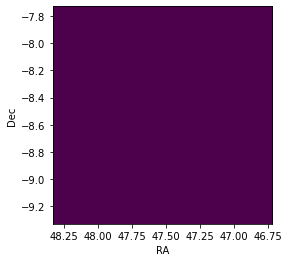

In [15]:
plt.figure()
plt.imshow(image, extent=[RA1,RAf,Dec1,Decf], cmap='BuPu_r',origin='lower')
plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()

At first glance, the image seems to be empty, however, let's change the _vmin_ and _vmax_ arguments from `imshow` and see if we can see any difference. 

Since the image is 3840x3840 pixels in size, let's only use a central smaller square to decide what limits to use (using the whole image will result in elevated computing time). A useful resource for choosing this limits is <a href="https://docs.astropy.org/en/stable/api/astropy.visualization.ZScaleInterval.html#astropy.visualization.ZScaleInterval">_ZScaleInterval_</a>, which calculates the image values near the median image, this is particularly useful for astronomical images, which generally have a very peaked histogram which can correspond to sky backgrounds.

In [16]:
cut = image[1850:-1850,1850:-1850]
interval = ZScaleInterval(nsamples=cut.size, contrast=1, max_reject=0.5)
vmin, vmax = interval.get_limits(cut)

print('Limits for image: vmin = ',vmin,', vmax = ',vmax)

Limits for image: vmin =  0.0 , vmax =  0.0012933474543723872


Now let's display the image again. The intensity maps contained in GALEX have the following units: $counts$/$pixel$/$s$, so we will include a colorbar to the image to see this variation.

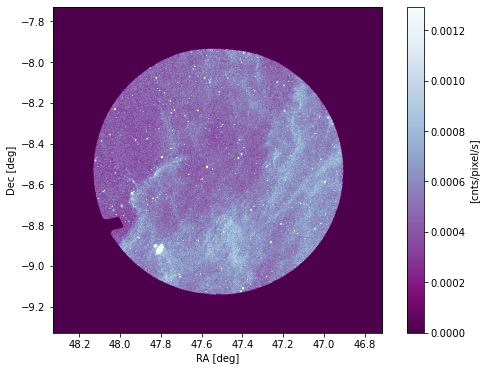

In [17]:
plt.figure(figsize=(9,6))
plt.imshow(image, extent=[RA1,RAf,Dec1,Decf], vmin=vmin, vmax=vmax, cmap='BuPu_r',origin='lower')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(label='[cnts/pixel/s]')
plt.show()

Great! Now we can actually see the contents of our image. As we stated at the beginning of this tutorial, this image corresponds to the [Molecular cloud MBM 15](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=mbm+15&submit=submit+id). This molecular cloud belong to the Orion-Eridanus superbubble, west of the Orion Nebula. More information about this can be found in [Joubaud et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...631A..52J/abstract).

## Exercises

Now that we have seen the whole process, let's try to do the same for a different target from the MBM catalog. Let's study now the molecular cloud LDN 1569.

Let's start again with the coordinates that SIMBAD provides for the [molecular cloud LDN 1569](http://simbad.cds.unistra.fr/simbad/sim-id?Ident=ldn+1569&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) (Gal. coordinates, ep = J2000):

- Galactic longitude: 189.1050 deg
- Galactic latitude: -36.0158 deg

### 1. Coordinate query and data downloading

Following the steps shown before, transform the coordinates from the Galactic frame to the ICRS, perform a query in the GALEX MIS database and download the UV intensity map corresponding to the coordinates provided.

In [18]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 2. Unzip the file and retrieve the information from the _.fits_ file

As we also saw before, the files in the GALEX database can be zipped in the form of _.gz_ files. First unzip the download file, and then retrieve the pertaining information contained in the _.fits_ file. Remember that we will need to use both the actual image and the information contained in the header!

In [19]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 3. Coordinate limits

Using the knowledge about the header information from before, calculate what will be the coordinate limits of our image for both the RA and Dec axes.

In [20]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 4. Define vmin and vmax for the image display

Let's use now `ZScaleInterval` and a central part of the image to decide the contrast that we will use on our image.

In [21]:
# You can copy, paste and modify the code corresponding to this part that we used before here


### 5. Display the final image

Now that you have all the ingredients, let's display the final image! Do not forget to include a colorbar with the proper units.

In [22]:
# You can copy, paste and modify the code corresponding to this part that we used before here


This image corresponds to a part of the molecular cloud LDN 1569 or MBM 18. This molecular cloud also belong to the Orion-Eridanus superbubble, but to the north rim in comparison with MBM 15 which is part of the west rim. For more information regarding this please refer to [Joubaud et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...631A..52J/abstract).

## Additional Resources

For more information about the MAST archive and details about the tutorial: 

* <a href="https://mast.stsci.edu/api/v0/index.html">MAST API</a> <br>
* <a href="https://galex.stsci.edu/GR6/">GALEX via MAST</a> <br>

## About this Notebook

**Author**: Clara Puerto Sánchez <br>
**Keyword(s)**: Tutorial, intensity map, dust <br>
**Last Updated**: Sep 2022 <br>
**Next review**: Apr 2023

For support, please contact the Archive HelpDesk at archive@stsci.edu.
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>